# Redefining cancer treatments

> Aim of this notebook is to practice coding in python and ML. Model focus will be: Random Forest Classifier.

The following workflow will be followed: 

1. Data exploration
2. Feature engineering
3. ML model with gene/variation alone 
    1. Train and predict
    2. Evaluate
4. ML model with text
    1. Train and predict
    2. Evaluate
    
### References
Notebooks used for inspiration:
- https://www.kaggle.com/headsortails/personalised-medicine-eda-with-tidy-r#header
- https://www.kaggle.com/dextrousjinx/brief-insight-on-genetic-variations
- https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm
    
# Background

Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature. For this competition MSKCC is making available an expert-annotated knowledge base where world-class researchers and oncologists have manually annotated thousands of mutations.

> **Problem statement:** Use machine learning to create a model that classifies genetic mutations based on clinical evidence (text).

## File descriptions

- **training_variants** - a comma separated file containing the description of the genetic mutations used for training. Fields are ID (the id of the row used to link the mutation to the clinical evidence), Gene (the gene where this genetic mutation is located), Variation (the aminoacid change for this mutations), Class (1-9 the class this genetic mutation has been classified on)
- **training_text** - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)
- **test_variants** - a comma separated file containing the description of the genetic mutations used for training. Fields are ID (the id of the row used to link the mutation to the clinical evidence), Gene (the gene where this genetic mutation is located), Variation (the aminoacid change for this mutations)
- **test_text** - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)
- **submissionSample** - a sample submission file in the correct format


## Loading libraries and files

In [23]:
import pandas as pd
import numpy as np
import os
import pandas_profiling
import scipy

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import scikitplot.metrics as skplt

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import maxabs_scale

# NLP
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer 
import spacy
import en_core_web_sm

# Text analysis helper libraries
from gensim.summarization import summarize
from gensim.summarization import keywords
from collections import Counter

# Model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

# ML classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Evaluation
from sklearn.metrics import log_loss, accuracy_score, classification_report

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

%load_ext autotime

# Parallelising
from pandarallel import pandarallel

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
INFO: Pandarallel will run on 112 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time: 19.4 ms


In [8]:
# Local
# train_var = pd.read_csv("C://Users/rhrey/OneDrive - University College London/Kaggling/redefining_cancer_trt/raw_data/training_variants")
# train_text = pd.read_csv("C://Users/rhrey/OneDrive - University College London/Kaggling/redefining_cancer_trt/raw_data/training_text", 
#                         sep = "\|\|", 
#                         engine = "python", 
#                         header = None, 
#                         skiprows = 1,
#                         names = ["ID", "Text"])

# Server
train_var = pd.read_csv("/data/kaggling/personalised_med/raw_data/msk-redefining-cancer-treatment/training_variants.zip")
train_text = pd.read_csv("/data/kaggling/personalised_med/raw_data/msk-redefining-cancer-treatment/training_text.zip", 
                         sep = "\|\|", 
                         engine = "python", 
                         header = None, 
                         skiprows = 1,
                         names = ["ID", "Text"])
train_var.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


time: 3.14 s


In [9]:
train_text.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


time: 11.8 ms


In [10]:
# Let's merge the two based on IDs, which we know they have in common.
train_merge = pd.merge(train_var, train_text, 
                       how = "inner", 
                       on = "ID")

# # And let's replace spaces in "Variation" with '_'
# train_merge.Variation = train_merge.Variation.str.replace('\s+', '_')

train_merge.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


time: 25.2 ms


# Data exploration

## Individual variables
- Pandas.DataFrame.profile_report() is a useful way of summarising individual variables once loaded into a DataFrame (N.B. this requires importing panda_profiling)

In [11]:
train_merge.profile_report()

time: 20.4 s


So what does this highlight?
1. A warning is provided that the columns "Gene", "Text" and "Variation" have high cardinality i.e. there are many distinct values --> this can be problematic in machine learning for two reasons:
    - Some algorithms may not tolerate categorical variables. This can be solved by converting these to *n* dummy variables for a categorical variable with length *n* distinct values.
    - High cardinality can require high computing resources.
2. Despite the high cardinality of "Gene", there are some genes that have a high frequency across the dataset. These are expected genes given the cancer context e.g. BRCA1/2, TP53, etc.
3. There is an imbalance in the classing of genetic mutations. In balanced system would expect ~11% of data to lie in each class, however, values range from 0.6-28.7% of the data. We will need to bear this in mind, both in terms of splitting out data into training, cross-validation and test, but also in terms of our algorithm.
4. Two observations of note with "Text" column:
    - Distinct count is only 1921, yet there are 3321 rows in this data. I.e. some abstracts are used multiple times (see 'Common values') albeit for different genetic variants.
    - 0.2% of our data has a missing text value. Let's have a quick check of these.

### Missing data

In [12]:
# Across columns, identify any with NA and index
# axis = 1 specifies this a row-wise operation
train_merge[train_merge.isna().any(axis = 1)]

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


time: 14.9 ms


In [13]:
# Given that we have the gene name and the variation, we can use this as a form of text
# Grab IDs for NA values
ids = train_merge[train_merge.isna().any(axis = 1)]["ID"]

# In text column with NAs concatenate Gene and Variation to provide text
train_merge.loc[ids, "Text"] = train_merge['Gene'] + ' ' +train_merge['Variation']

# Let's check this is what has happened
train_merge.loc[ids,]

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,FANCA S1088F
1277,1277,ARID5B,Truncating Mutations,1,ARID5B Truncating Mutations
1407,1407,FGFR3,K508M,6,FGFR3 K508M
1639,1639,FLT1,Amplification,6,FLT1 Amplification
2755,2755,BRAF,G596C,7,BRAF G596C


time: 15.1 ms


## Variable interactions e.g. gene vs class and gene vs variant


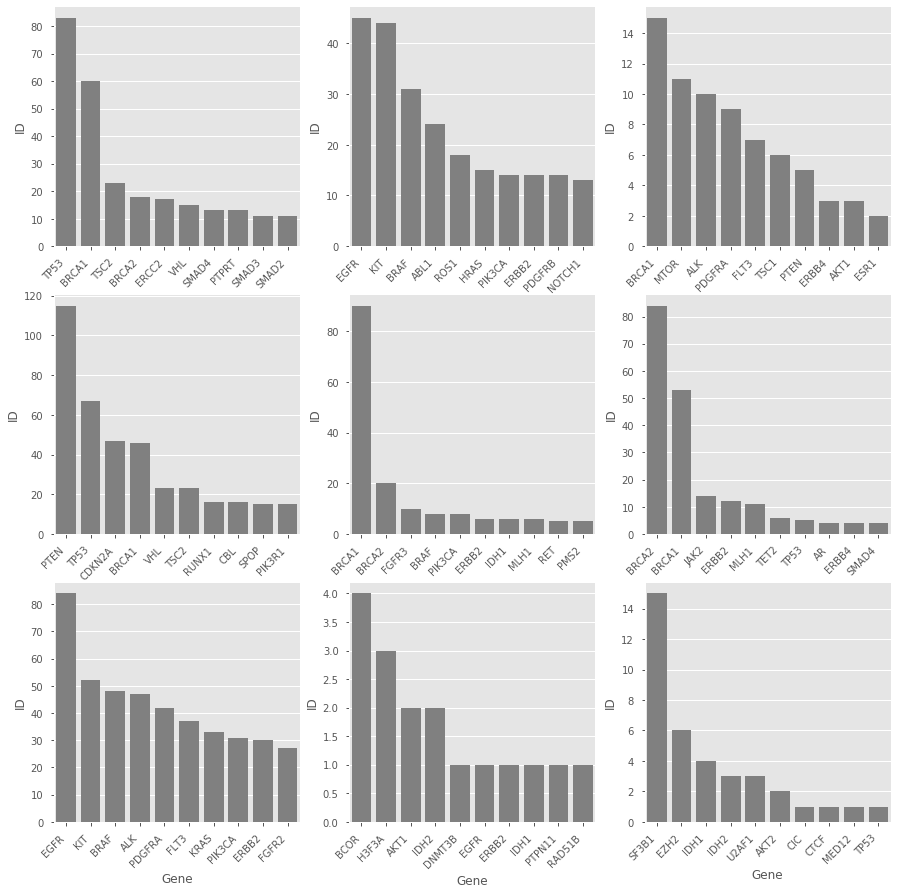

time: 2.79 s


In [14]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        gene_count_grp = train_merge[train_merge["Class"]==((i*3+j)+1)].groupby("Gene")["ID"].count().reset_index()
        sorted_gene_group = gene_count_grp.sort_values("ID", ascending=False)
        plot = sns.barplot(x = "Gene", y = "ID", data = sorted_gene_group[:10], color = "grey", ax = axs[i][j])
        plot.set_xticklabels(plot.get_xticklabels(), rotation = 45, horizontalalignment = "right")

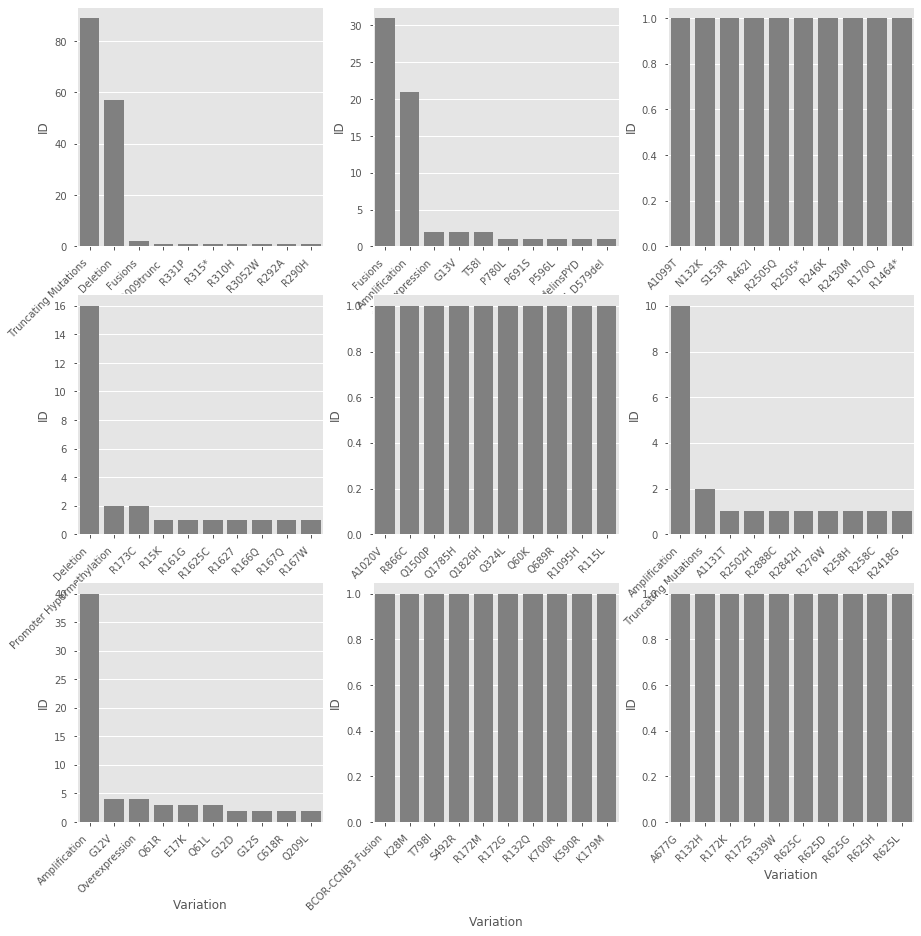

time: 2.47 s


In [15]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        variant_count_grp = train_merge[train_merge["Class"]==((i*3+j)+1)].groupby("Variation")["ID"].count().reset_index()
        sorted_variant_group = variant_count_grp.sort_values("ID", ascending=False)
        plot = sns.barplot(x = "Variation", y = "ID", data = sorted_variant_group[:10], color = "grey", ax = axs[i][j])
        plot.set_xticklabels(plot.get_xticklabels(), rotation = 45, horizontalalignment = "right")

From the above two plots we can say that:
- It is possible to somewhat distinguish between classes based on the top genes and/or variants in each class. 
- Based on genes alone, we can see several known cancer genes e.g. oncogenes (EGFR, BRAF, KIT) and tumour suppressors (P53, BRCA1/2, PTEN, VHL, SMAD4) 
    
Thus, as a baseline model will want to train using gene + variant alone. Any text-based model should outperform the gene + variant model alone.

## Splitting into training and test data
- Use a 80:20 split, ensuring that distribution of classes and genes is the same across the splits. 
- Will also split training data into cross-validation, prior to running ML model.
- At a later stage, may want to think about bootstrapping this split to ensure split itself does not bias algorithm.
- For splitting the data we can use the `sklearn.model_selection` function.

In [16]:
y_label = train_merge["Class"].values

# Split training dataframe into train and test
X_train, X_test, y_train, y_test = train_test_split(train_merge, 
                                                    y_label, 
                                                    stratify = y_label, 
                                                    train_size = 0.8, 
                                                    test_size = 0.2, 
                                                    random_state = 123)

## Comment in if want to split train into train and cv
# X_train, X_cv, y_train, y_cv = train_test_split(X_train, 
#                                                y_train, 
#                                                stratify = y_train, 
#                                                train_size = 0.75,
#                                                test_size = 0.25, 
#                                               random_state = 123)

# Let's check their dimensions
print('Training data, dimensions:', X_train.shape[0])
# print('Cross-validation data, dimensions:', X_cv.shape[0])
print('Test data, dimensions:', X_test.shape[0])

Training data, dimensions: 2656
Test data, dimensions: 665
time: 26.9 ms


In [17]:
# And let's check the distribution of the various classes
dist = pd.merge((X_train["Class"].value_counts()/X_train["Class"].value_counts().sum()).rename_axis("Class").reset_index(name = "Train"),
        (X_test["Class"].value_counts()/X_test["Class"].value_counts().sum()).rename_axis("Class").reset_index(name = "Test"),
        on = "Class")

## Comment in if CV dataset also included
# dist = pd.merge(dist,
#              (X_cv["Class"].value_counts()/X_cv["Class"].value_counts().sum()).rename_axis("Class").reset_index(name = "CV"),
#                on = "Class")

dist

,Class,Train,Test
0,7,0.286898,0.287218
1,4,0.206702,0.206015
2,1,0.170934,0.171429
3,2,0.135919,0.136842
4,6,0.082831,0.082707
5,5,0.073042,0.072180
6,3,0.026732,0.027068
7,9,0.011295,0.010526
8,8,0.005648,0.006015


time: 39.1 ms


Imbalance across classes is maintained within the split of the training data.

In [18]:
dist = pd.merge((X_train["Gene"].value_counts()/X_train["Gene"].value_counts().sum()).rename_axis("Gene").reset_index(name = "Train"),
        (X_test["Gene"].value_counts()/X_test["Gene"].value_counts().sum()).rename_axis("Gene").reset_index(name = "Test"),
        on = "Gene")

## Comment in if CV dataset also included
# dist = pd.merge(dist,
#               (X_cv["Gene"].value_counts()/X_cv["Gene"].value_counts().sum()).rename_axis("Gene").reset_index(name = "CV"),
#                on = "Gene")

dist

,Gene,Train,Test
0,BRCA1,0.081325,0.072180
1,TP53,0.048946,0.049624
2,EGFR,0.040663,0.049624
3,PTEN,0.038780,0.034586
4,BRCA2,0.038780,0.033083
...,...,...,...
136,NOTCH2,0.000377,0.001504
137,DNMT3A,0.000377,0.003008
138,MGA,0.000377,0.001504
139,XPO1,0.000377,0.001504


time: 42.2 ms


Recall that there were 264 distinct genes in our complete training data set. Yet here, there are only ~140 genes in common between the datasets. For now, let's leave this, but it adds to the argument that it may be worthwhile bootsrapping across the splitting of this data.

# Feature engineering

Currently, we have 3 features i.e. 'Gene', 'Variation' and 'Text'. Let's start by dealing with gene and variation.

### Gene and variation
- 'Gene' and 'Variation' will need to be converted into an appropriate format the machine learning algorithm understands.
- This can be done by:
    1. Label Encoder. This basically converts each text entry in the original column into a number. Problem with this is that because the numbers are still in the same column, the model misunderstands the data as being in some kind of order. **This is not the case for this data.**
    2. One Hot Encoder. If we have a column with *n* unique entries, this will create *n* columns, with each row having only one 1 in the appropriate column that represents the categorical variable in question. Similar concept to creating dummy variables in regression. **This is what we will use.**
- For reference see: https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621

In [39]:
# Number of unique gene entries
print('Number of Unique Genes :', X_train["Gene"].value_counts().shape[0])

Number of Unique Genes : 250
time: 4.83 ms


In [40]:
# One hot encoding for gene
gene_vectorizer = CountVectorizer()
X_train_gene_onehot = gene_vectorizer.fit_transform(X_train["Gene"])
X_train_gene_onehot.shape

(2656, 249)

time: 26.6 ms


In [41]:
# Number of unique variation entries
print('Number of Unique Variations :', X_train["Variation"].value_counts().shape[0])

Number of Unique Variations : 2400
time: 6.69 ms


In [42]:
# One hot encoding for gene
var_vectorizer = CountVectorizer()
X_train_var_onehot = var_vectorizer.fit_transform(X_train["Variation"])
X_train_var_onehot.shape

(2656, 2434)

time: 50.6 ms


In [43]:
# Combine the two features
X_train_onehot = scipy.sparse.hstack((X_train_gene_onehot, X_train_var_onehot))
print("(number of data points * number of features) in train data = ", X_train_onehot.shape)

(number of data points * number of features) in train data =  (2656, 2683)
time: 4.42 ms


## Text
- 'Text' - we will need to transform this into something that can then be used to predict the class of our gene-variant combination.
- How can we do this? Natural language processing (NLP), which allows us to process and analyse natural language.
- There are a number of NLP libraries available for python: https://medium.com/@srimanikantapalakollu/top-5-natural-language-processing-python-libraries-for-data-scientist-32463d36feae
- Will try two different libraries:
    - NLTK library is recommended as a good place to start for beginners
    - spaCy, which is said to be easy for applied data scientists to use and powerful.
 
### Cleaning up the text
- We will need to clean and process the articles in each row.
- Cleaning will involve:
    - Removing punctuation
    - Removing "stop-words"
    - Reducing the number of common words by reducing related forms of a word to a common base form. This can be done by stemming or lemmatisation, where stemming chops off the ends of words, and lemmatisation attempts to return words to the dictionary form of a word.

Let's start by loading in the necessary stop word and punctuation references.

In [19]:
nlp = en_core_web_sm.load()

time: 1.13 s


In [20]:
# Import stop words and punctuation
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

# Additional words
custom_words = ["fig", "figure", "et", "al", "al.", "also",
                "data", "analyze", "study", "table", "using",
                "method", "result", "conclusion", "author", 
                "find", "found", "show", "abstract", "background",
                "methods", '"', "’", "“", "”"]

stop_words = set(list(STOP_WORDS) + list(punctuation) + custom_words)

# Customise stop words to include additional words
for word in custom_words:
    nlp.vocab[word].is_stop = True

time: 4.61 ms


### Using NLTK

- Let's start by tokenising and cleaning the text using NLTK functions.
- Text will be lemmatised, and this will be performed over texts that are grouped by:
    - Gene and Class -- this will be used in final model, as want to use both features for model
    - Class alone -- this allows us to look at work frequencies within a class.

In [89]:
# Grouping by Gene and Class
# Remove duplicate Gene, Class, Text instances
class_gene_corpus = X_train[["Gene", "Class", "Text"]].drop_duplicates(subset= ["Gene", "Class", "Text"]). \
    groupby(["Gene", "Class"]).apply(lambda x: x["Text"].str.cat()) # For each gene and class, concatenate the text available

# Grouping only by class
class_corpus = X_train[["Gene", "Class", "Text"]].drop_duplicates(subset= ["Class", "Text"]). \
    groupby(["Class"]).apply(lambda x: x["Text"].str.cat()) # For each gene and class, concatenate the text available


time: 1.49 s


In [ ]:
# Import lemmatiser function
wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()

# Initialise parallel processors
pandarallel.initialize(nb_workers = 20)

# Lemmatise words, turn them into lower case and remove set of stop words (including puncuation) and digits
# Do this for both class corpus and gene + class corpus
tokenised_class_gene_corpus = class_gene_corpus.parallel_apply(lambda x: Counter([wordnet_lemmatizer.lemmatize(w) 
                                                      for w in word_tokenize(x) 
                                                      if w.lower() not in stop_words and not w.isdigit()]))

tokenised_class_corpus = class_corpus.apply(lambda x: Counter([wordnet_lemmatizer.lemmatize(w) 
                                                      for w in word_tokenize(x) 
                                                      if w.lower() not in stop_words and not w.isdigit()]))

Let's now check the frequency of word per class.

In [59]:
class_corpus.apply(lambda x: x.most_common(20))
class_freq = pd.DataFrame.from_records(class_freq.values.tolist()).set_index(class_freq.index)

TypeError: unhashable type: 'Counter'

time: 72.5 ms


### Using spaCy

In [37]:
df = X_train[0:5]

tokens = []
lemma = []

for doc in nlp.pipe(df["Text"].astype('unicode').values, disable=['ner'],
                    batch_size=50,
                    n_threads=112):
    if doc.is_parsed:
        tokens.append([n.text for n in doc if n.is_alpha and not n.is_stop and n.pos_ != "PUNCT" and n.pos_ != "SYM"])
        lemma.append([n.lemma_ for n in doc if n.is_alpha and not n.is_stop and n.pos_ != "PUNCT" and n.pos_ != "SYM"])
        # sentences.append([[token.text for token in sent] for sent in doc.sents])

    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)


df = df.assign(tokens = tokens)
df = df.assign(lemma = lemma)

# # Tried saving, but when re-loaded did not have same format as when saved.
# df.to_csv(path_or_buf = "C://Users/rhrey/OneDrive - University College London/Kaggling/redefining_cancer_trt/results/tokenised_data.txt", index = False)

df.head()

,ID,Gene,Variation,Class,Text,tokens,lemma
1631,1631,MAP2K4,R228K,4,The systematic characterization of somatic mut...,"[systematic, characterization, somatic, mutati...","[systematic, characterization, somatic, mutati..."
2920,2920,NFE2L2,T80K,7,One of the strategies proposed for the chemopr...,"[strategies, proposed, chemoprevention, degene...","[strategy, propose, chemoprevention, degenerat..."
2031,2031,MAP2K1,D67N,7,The MAPK/ERK pathway (RAS–RAF–MEK–ERK pathway)...,"[MAPK, ERK, pathway, RAS, RAF, MEK, ERK, pathw...","[MAPK, ERK, pathway, RAS, RAF, MEK, ERK, pathw..."
2203,2203,PTEN,A126V,4,The PTEN (phosphatase and tensin homolog) phos...,"[PTEN, phosphatase, tensin, homolog, phosphata...","[PTEN, phosphatase, tensin, homolog, phosphata..."
2811,2811,BRCA2,N1102Y,6,Mutation screening of the breast and ovarian c...,"[Mutation, screening, breast, ovarian, cancer,...","[mutation, screening, breast, ovarian, cancer,..."


time: 4.55 s


From this we can take a quick look at the most common words in each class.

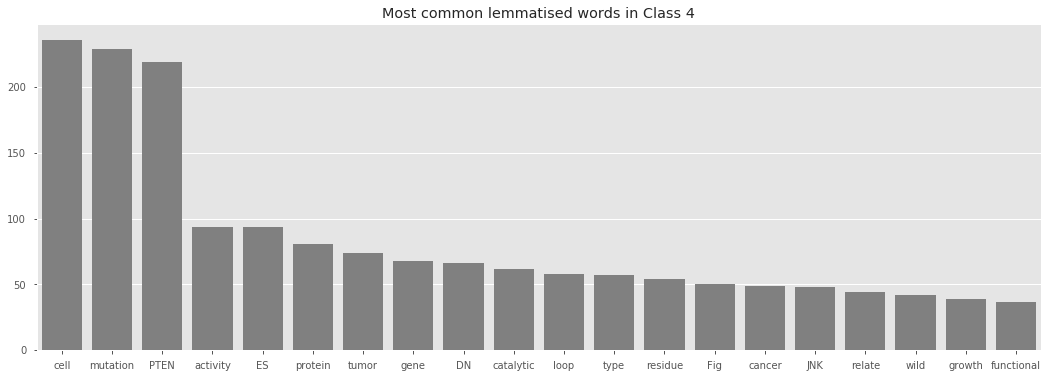

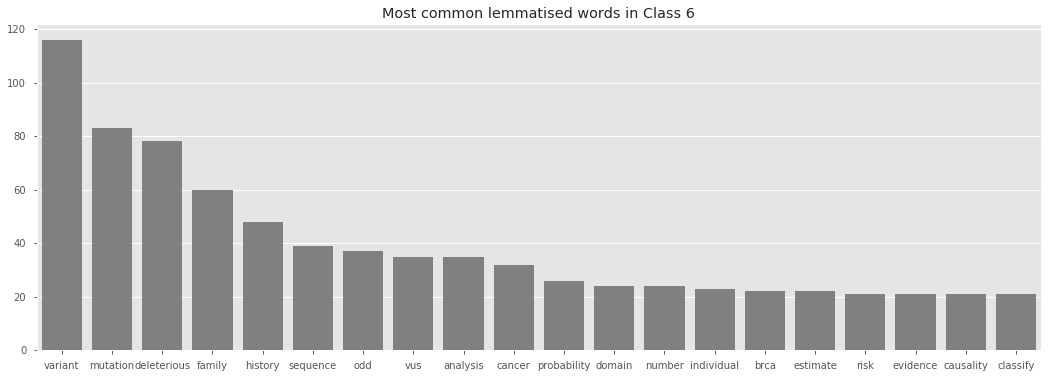

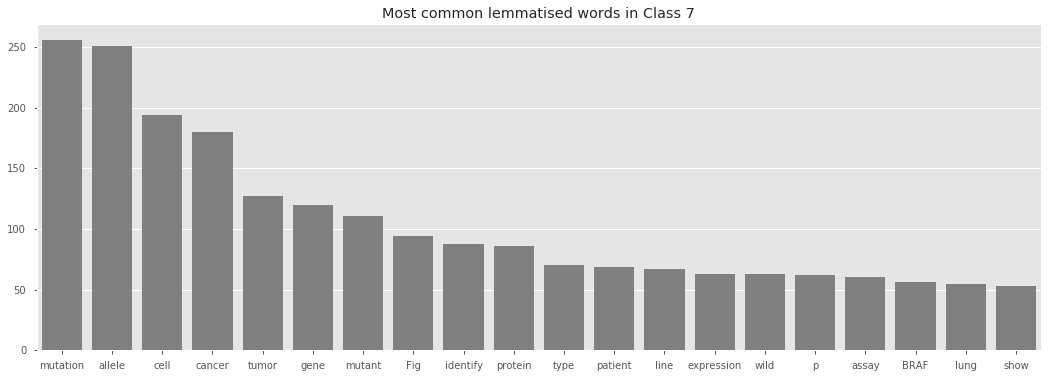

time: 1.35 s


In [38]:
for i in sorted(df.Class.unique()):
    subset = df.loc[df["Class"] == i]
    lemma = np.hstack(subset["lemma"].values)
    common = Counter(lemma).most_common(20)
    words = [word[0] for word in common]
    counts = [word[1] for word in common]
    fig = plt.figure(figsize=(18,6))
    sns.barplot(x = words, y = counts, color = "grey")
    plt.title("Most common lemmatised words in Class " + str(i))
    plt.show()

- While spaCy works well in terms of cleaning the data, it is very slow i.e. 6s for 5 entries, therefore (6s/60s) * (2600/5) ~ 52 minutes.
- This could be sped up by removing duplicate columns, as done with NLTK.
- Also, currently do not know how to save the object to preserve the structure of it.

# Baseline model: gene + variant

> Aim: train a Random Forest Classifier using gene and variant alone

This will be used to establish our baseline, which our text-based model must outperform.

To begin with, we use a helper function (forked from: https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm) to evaluate the effectiveness of the model. 
- This function uses *k*-fold cross-validation. While this is computationally expensive, the benefit is that it does not waste data (as is the case when fixing an arbitrary validation set from the training set), which is helpful when datasets are small. Given that some of our classes are very small, this might be beneficial.
- In k-fold cross-validation with `cross_val_predict` the following happens:
    1. Split training data into *k* smaller sets.
    2. For each *k* "fold", a model is trained using *k* - 1 of the folds as training data. The last subset is used to predict labels.
- As we have a class imbalance, we perform *k*-fold cross-validation with `StratifiedKFold`. This ensures that relative class frequencies are preserved.
- Guide to cross-validation: https://towardsdatascience.com/cross-validation-a-beginners-guide-5b8ca04962cd

In [44]:
# Code forked from: https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm 
def evaluate_features(X, y_true, clf=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        clf = LogisticRegression()
    
    probas = cross_val_predict(clf, 
                               X, 
                               y_true, 
                               cv=StratifiedKFold(random_state=8), # StratifiedKFold preserves relative class frequencies.
                               n_jobs=-1, 
                               method='predict_proba', # Columns correspond to classes in sorted order
                               verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y_true)
    y_pred = classes[pred_indices]
    print("Log loss: {}".format(log_loss(y_true, probas)))
    print("Model metrics: \n")
    print(classification_report(y_true, y_pred, digits=3))
    skplt.plot_confusion_matrix(y_true, y_pred)


time: 3.78 ms


With this function we will be evaluating:
- **Log Loss.** This takes into account the uncertainty of your prediction based on how much it varies from the actual label. This gives us a more nuanced view into the performance of our model.
- **Precision.** Ratio of correctly redicted positive observations to the total predicted positive observations i.e. TP/(TP + FP).
- **Recall.** Ratio of correctly predicted positive observations to all observations in the class i.e. TP/(TP + FN)
- **F1 score.** Weighted average of Precision and Recall -- that is, takes both FP and FN into account i.e. 2 * (Recall * Precision)/(Recall + Precision)
    -  A downside of F1 score is that equal weight is assigned to precision and recall, when in fact this may not be the case in reality. E.g. classifying someone as sick as opposed to healthy has a different cost.
- **Confusion matrix.** Visualisation of predicted and expected results. With 100% accuracy would expect all values to lie on the diagonal i.e. predicted = true values. If not, confusion matrix can give us an idea of the types of error the model is making.

## Gene alone

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 112 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.3s finished


Log loss: 1.658685170384813
Model metrics: 

              precision    recall  f1-score   support

           1      0.475     0.062     0.109       454
           2      1.000     0.003     0.006       361
           3      0.000     0.000     0.000        71
           4      0.705     0.313     0.434       549
           5      0.000     0.000     0.000       194
           6      0.500     0.059     0.106       220
           7      0.327     0.997     0.492       762
           8      0.000     0.000     0.000        15
           9      0.000     0.000     0.000        30

    accuracy                          0.367      2656
   macro avg      0.334     0.159     0.127      2656
weighted avg      0.498     0.367     0.259      2656



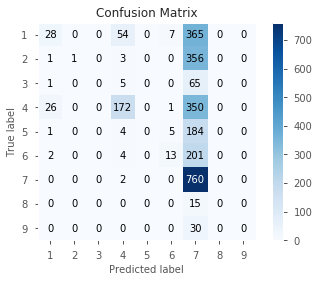

time: 9.06 s


In [45]:
evaluate_features(X = X_train_gene_onehot, 
                  y_true = y_train, 
                  clf = RandomForestClassifier(n_estimators=1000, # Number of trees in the forest
                                               max_depth=5, # Maximum depth of a tree
                                               verbose=1))

- Classifier appears to be predominantly labelling as class 7, which is also the class with the most training data.

## Variation alone

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 112 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished


Log loss: 1.7950520197551092
Model metrics: 

              precision    recall  f1-score   support

           1      0.944     0.150     0.259       454
           2      0.000     0.000     0.000       361
           3      0.000     0.000     0.000        71
           4      0.000     0.000     0.000       549
           5      0.000     0.000     0.000       194
           6      0.000     0.000     0.000       220
           7      0.295     1.000     0.455       762
           8      0.000     0.000     0.000        15
           9      0.000     0.000     0.000        30

    accuracy                          0.312      2656
   macro avg      0.138     0.128     0.079      2656
weighted avg      0.246     0.312     0.175      2656



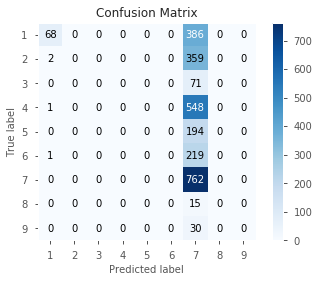

time: 3.93 s


In [46]:
evaluate_features(X = X_train_var_onehot, 
                  y_true = y_train, 
                  clf = RandomForestClassifier(n_estimators=1000, # Number of trees in the forest
                                               max_depth=5, # Maximum depth of a tree
                                               verbose=1))

- Variation alone appears to perform even more poorly than gene alone, with predictions again falling into class 7.

## Gene + variant

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 112 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


Log loss: 1.7102805305677955
Model metrics: 

              precision    recall  f1-score   support

           1      0.932     0.150     0.258       454
           2      1.000     0.003     0.006       361
           3      0.000     0.000     0.000        71
           4      0.916     0.199     0.326       549
           5      0.000     0.000     0.000       194
           6      0.000     0.000     0.000       220
           7      0.309     0.999     0.472       762
           8      0.000     0.000     0.000        15
           9      0.000     0.000     0.000        30

    accuracy                          0.354      2656
   macro avg      0.351     0.150     0.118      2656
weighted avg      0.573     0.354     0.248      2656



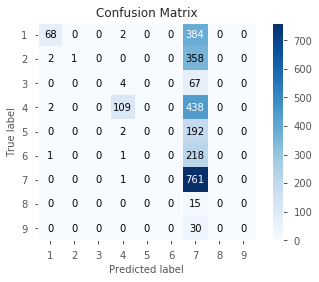

time: 3.84 s


In [47]:
evaluate_features(X = X_train_onehot, 
                  y_true = y_train, 
                  clf = RandomForestClassifier(n_estimators=1000, # Number of trees in the forest
                                               max_depth=5, # Maximum depth of a tree
                                               verbose=1))

- Gene and variant together do not perform as well as gene alone, thus baseline metrics that our text-based model has to outperform are:
    - Log loss: 1.66
    - F1 score: 0.368

# Text-based model